Processing Masks: 100%|██████████| 4494/4494 [03:48<00:00, 19.69it/s]
C:\Users\USER\AppData\Local\Temp\ipykernel_26376\897769656.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(



=== Hasil Distribusi Kelas ===
                         Class  Pixel Count  Percentage
0                   Background  28170173720   52.173377
1                        Water   4358798120    8.072837
2           Building No Damage   1430042011    2.648550
3        Building Minor Damage   1411706150    2.614591
4        Building Major Damage    889425801    1.647287
5   Building Total Destruction    768173839    1.422718
6                      Vehicle    179431786    0.332322
7                 Road-Blocked   3763278379    6.969888
8                   Road-Clear    847068928    1.568838
9                         Tree  12144273059   22.492149
10                        Pool     31015727    0.057444


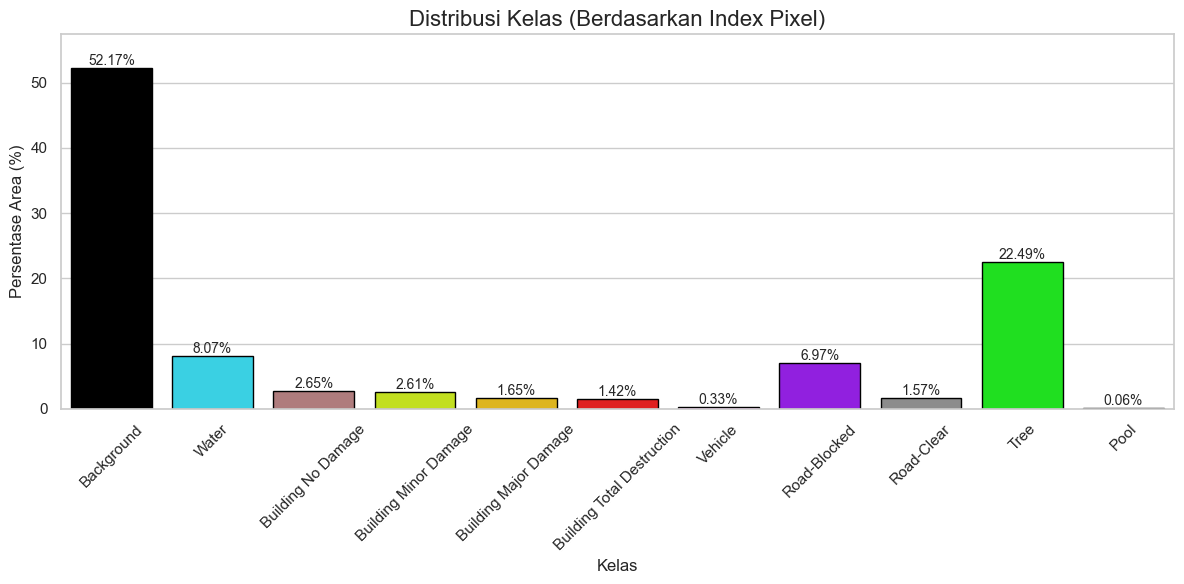

In [18]:
import os
import glob
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

DATASET_ROOT = '../RescueNet/dataset/'

id2label = {
    0: "Background",
    1: "Water",
    2: "Building No Damage",
    3: "Building Minor Damage",
    4: "Building Major Damage",
    5: "Building Total Destruction",
    6: "Vehicle",
    7: "Road-Blocked",
    8: "Road-Clear",
    9: "Tree",
    10: "Pool"
}

CLASS_NAMES = [id2label[i] for i in range(len(id2label))]

LABEL_COLORS = [
    [0, 0, 0],          # 0: Background 
    [30, 230, 255],     # 1: Water 
    [184, 115, 117],    # 2: Building No Damage 
    [216, 255, 0],      # 3: Building Minor Damage 
    [252, 199, 0],      # 4: Building Major Damage 
    [255, 0, 0],        # 5: Building Total Destruction 
    [255, 0, 246],      # 6: Vehicle 
    [151, 0, 255],      # 7: Road-Blocked 
    [140, 140, 140],    # 8: Road-Clear 
    [0, 255, 0],        # 9: Tree 
    [244, 255, 0]       # 10: Pool 
]

PLOT_COLORS = [
    '#000000', # 0: Background (Hitam)
    '#1EE6FF', # 1: Water (Cyan)
    '#B87375', # 2: Building No Damage (Merah Bata Pudar)
    '#D8FF00', # 3: Building Minor Damage (Kuning Lime)
    '#FCC700', # 4: Building Major Damage (Emas/Oranye)
    '#FF0000', # 5: Building Total Destruction (Merah)
    '#FF00F6', # 6: Vehicle (Pink Magenta)
    '#9700FF', # 7: Road-Blocked (Ungu)
    '#8C8C8C', # 8: Road-Clear (Abu-abu)
    '#00FF00', # 9: Tree (Hijau)
    '#F4FF00'  # 10: Pool (Kuning Terang)
]

def calculate_distribution_torch(dataset_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_classes = len(CLASS_NAMES)
    total_counts = torch.zeros(num_classes, dtype=torch.long).to(device)
    
    label_files = []
    subsets = ['train', 'val', 'test']
    
    for subset in subsets:
        lbl_dir = os.path.join(dataset_path, subset, f'{subset}-label-img')
        if os.path.exists(lbl_dir):
            files = glob.glob(os.path.join(lbl_dir, '*'))
            label_files.extend(files)
            
    for lbl_path in tqdm(label_files, desc="Processing Masks"):
        img_np = cv2.imread(lbl_path, cv2.IMREAD_UNCHANGED)
        
        if img_np is None:
            continue
            
        if len(img_np.shape) == 3:
            img_np = img_np[:, :, 0]
        
        img_tensor = torch.from_numpy(img_np).long().to(device).flatten()
        
        counts = torch.bincount(img_tensor, minlength=num_classes)
        
        if len(counts) > num_classes:
            counts = counts[:num_classes]
            
        total_counts += counts

    return total_counts.cpu().numpy()


def plot_results(counts):
    total_pixels = np.sum(counts)
    
    data = []
    for idx, count in enumerate(counts):
        percentage = (count / total_pixels) * 100 if total_pixels > 0 else 0
        data.append({
            'Class': CLASS_NAMES[idx],
            'Pixel Count': count,
            'Percentage': percentage
        })
        
    df = pd.DataFrame(data)
    
    print("\n=== Hasil Distribusi Kelas ===")
    print(df)
    
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    barplot = sns.barplot(
        data=df,
        x='Class',
        y='Percentage',
        palette=PLOT_COLORS,
        edgecolor='black'
    )
    
    plt.title('Distribusi Kelas (Berdasarkan Index Pixel)', fontsize=16)
    plt.xlabel('Kelas', fontsize=12)
    plt.ylabel('Persentase Area (%)', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, max(df['Percentage']) * 1.1) 
    
    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.2f}%', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


pixel_counts = calculate_distribution_torch(DATASET_ROOT)
plot_results(pixel_counts)

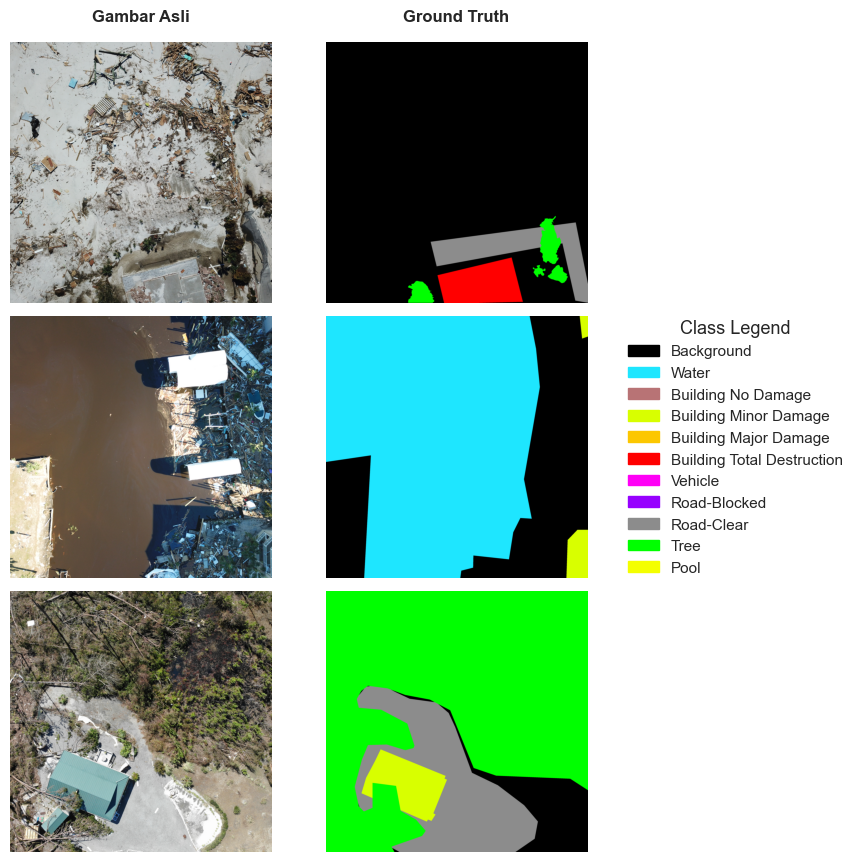

In [ ]:
def crop_center_square(img):
    width, height = img.size
    new_dim = min(width, height)
    
    left = (width - new_dim) / 2
    top = (height - new_dim) / 2
    right = (width + new_dim) / 2
    bottom = (height + new_dim) / 2
    
    return img.crop((left, top, right, bottom))

def save_visualization_result(image_ids, output_filename="hasil_visualisasi_rescuenet.png"):
    sns.set_style("white")
    
    num_images = len(image_ids)
    
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(8, 3 * num_images))
    
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    plt.subplots_adjust(left=0.05, right=0.82, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

    for i, img_id in enumerate(image_ids):
        original_filename = f"{img_id}.jpg"
        ground_truth_filename = f"{img_id}_lab_mapped.png"
        
        ax_orig = axes[i, 0]
        if os.path.exists("sample_rescuenet/"+original_filename):
            img = Image.open("sample_rescuenet/"+original_filename).convert("RGB")
            img = crop_center_square(img) 
            ax_orig.imshow(img)
        else:
            ax_orig.text(0.5, 0.5, "Not Found", ha='center')
        
        if i == 0:
            ax_orig.set_title("Gambar Asli", fontsize=12, fontweight='bold', pad=15)
        
        ax_orig.axis("off")
        
        ax_gt = axes[i, 1]
        if os.path.exists("sample_rescuenet/"+ground_truth_filename):
            gt_img = Image.open("sample_rescuenet/"+ground_truth_filename).convert("RGB")
            gt_img = crop_center_square(gt_img) 
            ax_gt.imshow(gt_img)
        else:
            ax_gt.text(0.5, 0.5, "Not Found", ha='center')

        if i == 0:
            ax_gt.set_title("Ground Truth", fontsize=12, fontweight='bold', pad=15)
            
        ax_gt.axis("off")

    patches = [
        mpatches.Patch(color=[c/255 for c in color], label=label)
        for label, color in zip(CLASS_NAMES, LABEL_COLORS)
    ]
    
    fig.legend(
        handles=patches,
        loc="center left",
        bbox_to_anchor=(0.83, 0.5), 
        title="Class Legend",
        fontsize="11",
        title_fontsize="13",
        frameon=False
    )
    
    plt.show(fig)

files = ["10794", "11343", "15210"]
save_visualization_result(files)